![House_Price_Overview](House_price_competition.png)

Kaggle Competition : {'Source' : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview}


## Goal
- It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

##  Module Import

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch

import warnings
warnings.filterwarnings('ignore')

In [104]:
#!pip install -U keras-tuner

In [189]:
train = pd.read_csv('Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('Data/house-prices-advanced-regression-techniques/test.csv')

In [190]:
train[:3]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [191]:
test.head(3)


## Test Set엔 Y값이 될 'SalePrice' 열이 없음 >> SalePrice행을 삭제한 후, Train셋과 합칠예정
## Test 데이터는 맨 마지막, Predict할때 쓰일 예정

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [192]:
X = pd.concat([train, test], axis = 0, sort = False)
X.drop(['SalePrice'], axis = 1, inplace = True)

y = train['SalePrice'].values

In [193]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (2919, 80)
y shape:  (1460,)


## Handling to Missing Value
![na_value](https://miro.medium.com/max/2880/1*5OfY4LnYRLPTDNU3Run9Jg.jpeg)
<br><br>
 * 출처 : https://pub.towardsai.net/handling-missing-values-in-pandas-f87cec928937</br>

In [194]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [195]:
# 결측치 확인

missing_values = X.isna().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
missing_values

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [196]:
nan_col = list(missing_values.to_dict())

In [197]:
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level = 0, inplace = True)
missing_values_data.columns = ['Feature', 'Number of Missing Values']

## 비율을 알아보자
missing_values_data['Percentage of Missing Values'] = (100.0 * missing_values_data['Number of Missing Values']) / len(X)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageFinish,159,5.447071
7,GarageQual,159,5.447071
8,GarageCond,159,5.447071
9,GarageYrBlt,159,5.447071


In [198]:
# 결측치 처리
X['BsmtFinSF1'].fillna(0, inplace = True)
X['BsmtFinSF2'].fillna(0, inplace = True)
X['TotalBsmtSF'].fillna(0, inplace = True)
X['BsmtUnfSF'].fillna(0, inplace = True)
X['Electrical'].fillna('FuseA', inplace = True)
X['KitchenQual'].fillna('TA', inplace = True)
X['LotFrontage'].fillna(X.groupby('1stFlrSF')['LotFrontage'].transform('mean'), inplace = True)
X['LotFrontage'].interpolate(method = 'linear', inplace = True)
X['MasVnrArea'].fillna(X.groupby('MasVnrType')['MasVnrArea'].transform('mean'), inplace = True)
X['MasVnrArea'].interpolate(method = 'linear', inplace = True)

In [199]:
for col in nan_col:
    data_type = X[col].dtype
    if data_type == 'object':
        X[col].fillna('NA', inplace = True)
    else:
        X[col].fillna(X[col].mean(), inplace = True)

## Adding to New Features

In [200]:
X['Total_Square_Feet'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF'])

X['Total_Bath'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))

X['Total_Porch_Area'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])

X['SqFtPerRoom'] = X['GrLivArea'] / (X['TotRmsAbvGrd'] + X['FullBath'] + X['HalfBath'] + X['KitchenAbvGr'])

## One-Hot Encoding
    - Categorical Feature = {'MSZoning', 'Street', 'LotShape', 'LandContour', ....}

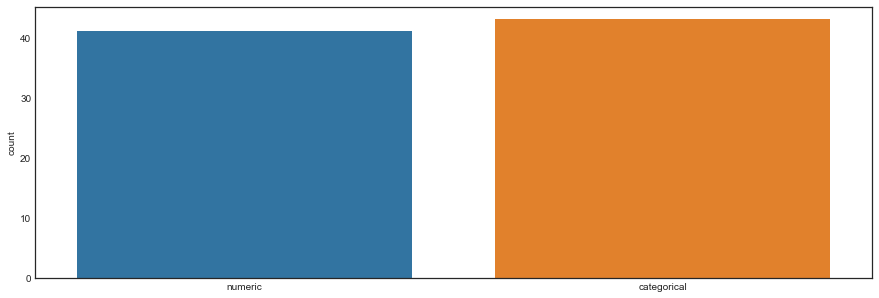

In [201]:
column_data_type = []
for col in X.columns:
    data_type = X[col].dtype
    if X[col].dtype in ['int64', 'float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
        
plt.figure(figsize = (15, 5))
sns.countplot(x = column_data_type)
plt.show()

In [202]:
X = pd.get_dummies(X)
X

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0,0,0,1,1,0,0,0,0,0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0,0,0,1,1,0,0,0,0,0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0,0,0,1,0,0,0,0,1,0


In [203]:
len(X)

2919

In [204]:
1460 / 2919

0.5001712915381981

### Train / Test dataset Split
- Split Percentage : Approximately `50%`

In [205]:
train = X[:1460].copy()
test = X[1460:].copy()
train['SalePrice'] = y

### EDA / Outliers Detection
- `corr()` Method
- Look up to every each feature's correlation >> Output : `Top 30`

<AxesSubplot:>

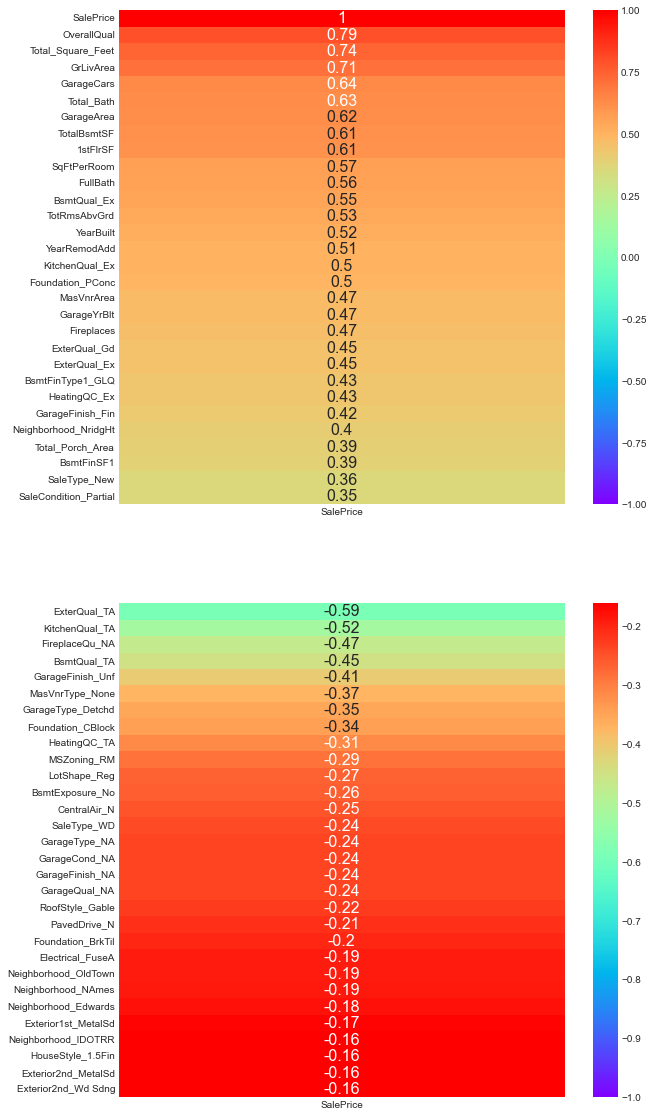

In [206]:
# 양의 상관관계
top_features = train.corr()[['SalePrice']].sort_values(by = ['SalePrice'], ascending = False).head(30)
# 음의 상관관계
minus_top_features = train.corr()[['SalePrice']].sort_values(by = ['SalePrice'], ascending = True).head(30)

#plt.figure(figsize = (5, 10))

# 시각화
fig, ax = plt.subplots(nrows=2, figsize = (10, 20))
sns.heatmap(top_features, cmap = 'rainbow', annot = True, annot_kws = {'size' : 16}, vmin = -1, ax = ax[0])
sns.heatmap(minus_top_features, cmap = 'rainbow', annot = True, annot_kws = {'size' : 16}, vmin = -1, ax = ax[1])

### 'SalePrice' Column / Outliers 

In [207]:
def plot_data(col, discrete = False):
    if discrete:
        fig, ax = plt.subplots(1, 2, figsize = (14, 6))
        sns.stripplot(x = col, y = 'SalePrice', data = train, ax = ax[0])
        sns.countplot(train[col], ax = ax[1])
        fig.suptitle(str(col) + 'Analysis')
    else:
        fig, ax = plt.subplots(1, 2, figsize = (12, 6))
        sns.scatterplot(x = col, y = 'SalePrice', data = train, ax = ax[0])
        sns.distplot(train[col], kde = False, ax = ax[1])
        fig.suptitle(str(col) + 'Analysis')

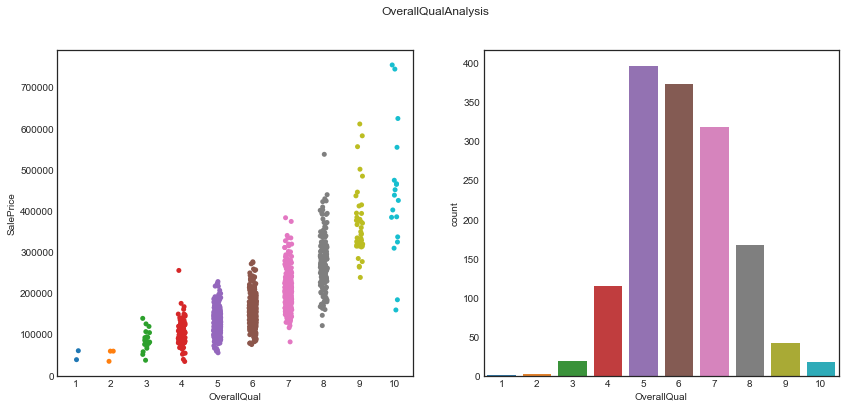

In [208]:
plot_data('OverallQual', True)

In [209]:
train = train.drop(train[(train['OverallQual'] == 10) & (train['SalePrice'] < 200000)].index)

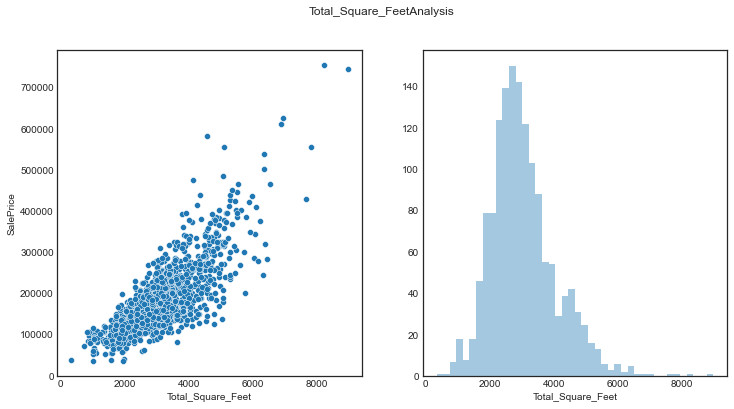

In [210]:
plot_data('Total_Square_Feet')

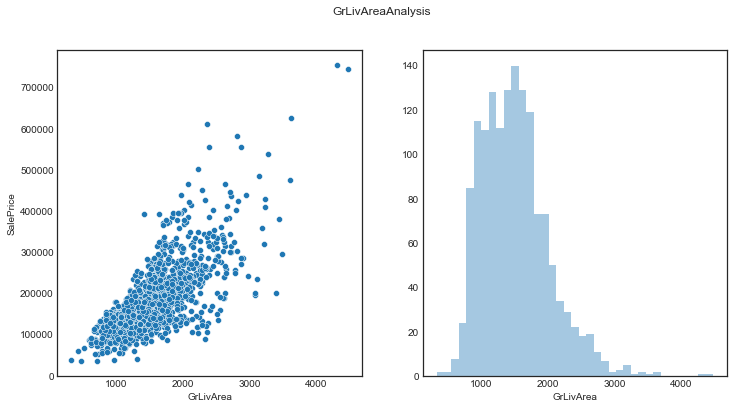

In [211]:
plot_data('GrLivArea')

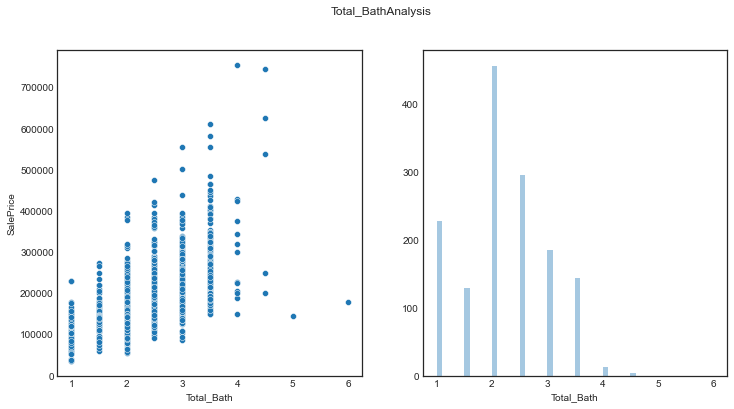

In [212]:
plot_data('Total_Bath')

In [213]:
train = train.drop(train[(train['Total_Bath'] > 4) & (train['SalePrice'] < 200000)].index)

In [214]:
train.reset_index()

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,1,0,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,1,0,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1455,1456,60,62.0,7917,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,1,0,175000
1452,1456,1457,20,85.0,13175,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,1,0,210000
1453,1457,1458,70,66.0,9042,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,1,0,266500
1454,1458,1459,20,68.0,9717,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,1,0,142125


#### IsolationForest을 이용한 이상탐지
- 모든 feature들을 다루고 모든 outliers를 제거하는건 어렵겠지만 각각의 값들이 'SalePrice'값과 높은 상관관계를 파악하는데 도움이될것.
-` 1` : 정상값 
- `-1` : 이상치

In [215]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)

y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

print('Number of Outliers: ', y_noano[y_noano['Top'] == -1].shape[0])
print('Number of rows without outliers: ', train.shape[0])

Number of Outliers:  12
Number of rows without outliers:  1444


In [216]:
y_noano.value_counts()

Top
 1     1444
-1       12
dtype: int64

In [217]:
len(train)

1444

#### 최종 X, y값 산출

In [218]:
X = train.copy()
X.drop(['SalePrice'], axis = 1, inplace = True)
y = train['SalePrice'].values

In [219]:
len(train.columns)

315

## Modeling
    - Build model
    - Hyperparamers Tuning ( RandomSearch API 활용해 최적의 파라미터값 산출 )

In [227]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(hp.Int('units_' + str(i), min_value = 32, max_value = 512, step = 32),
                       activation = 'relu'))
        model.add(Dense(1))
        
        model.compile(optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                     loss = 'mse',
                     metrics = ['mse'])
        
        return model

In [221]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=(X[:1100],y[:1100]))

Trial 10 Complete [00h 00m 29s]
val_mse: 2451280469.3333335

Best val_mse So Far: 1399785173.3333333
Total elapsed time: 00h 04m 50s
INFO:tensorflow:Oracle triggered exit


In [222]:
model = tuner.get_best_models(1)[0]

- 데이터셋에 가장 효율적인 파라미터의 값들을 찾은 후, 분리된 다른 모델에 적용

### Create Independent Model

In [223]:
def create_model():
    model = Sequential()
    model.add(Dense(320, input_dim = X.shape[1], activation = 'relu'))
    model.add(Dense(384, activation = 'relu'))
    model.add(Dense(352, activation = 'relu'))
    model.add(Dense(448, activation = 'relu'))
    model.add(Dense(160, activation = 'relu'))
    model.add(Dense(160, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer = Adam(learning_rate = 0.0001),
                 loss = 'mse')
    
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 320)               100800    
                                                                 
 dense_3 (Dense)             (None, 384)               123264    
                                                                 
 dense_4 (Dense)             (None, 352)               135520    
                                                                 
 dense_5 (Dense)             (None, 448)               158144    
                                                                 
 dense_6 (Dense)             (None, 160)               71840     
                                                                 
 dense_7 (Dense)             (None, 160)               25760     
                                                                 
 dense_8 (Dense)             (None, 32)               

### EarlyStopping Callback
    - 1/10 Train_data
    - Overfitting 방지를 위한 Val_data에 최적화된 epoch수 사용

Epoch 1/1000
11/11 [==============================] - 1s 27ms/step - loss: 39443288064.0000 - val_loss: 36446314496.0000
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 39136202752.0000 - val_loss: 36036575232.0000
Epoch 3/1000
11/11 [==============================] - 0s 4ms/step - loss: 38507057152.0000 - val_loss: 35077791744.0000
Epoch 4/1000
11/11 [==============================] - 0s 4ms/step - loss: 36956803072.0000 - val_loss: 32744370176.0000
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 33360459776.0000 - val_loss: 27326703616.0000
Epoch 6/1000
11/11 [==============================] - 0s 4ms/step - loss: 25787633664.0000 - val_loss: 16938295296.0000
Epoch 7/1000
11/11 [==============================] - 0s 4ms/step - loss: 14436219904.0000 - val_loss: 6236220928.0000
Epoch 8/1000
11/11 [==============================] - 0s 4ms/step - loss: 13317327872.0000 - val_loss: 5141412864.0000
Epoch 9/1000
11/11 [=====================

Epoch 70/1000
11/11 [==============================] - 0s 6ms/step - loss: 1500154240.0000 - val_loss: 1282813056.0000
Epoch 71/1000
11/11 [==============================] - 0s 5ms/step - loss: 1524833152.0000 - val_loss: 1228090624.0000
Epoch 72/1000
11/11 [==============================] - 0s 6ms/step - loss: 1508054400.0000 - val_loss: 1320689792.0000
Epoch 73/1000
11/11 [==============================] - 0s 8ms/step - loss: 1498936448.0000 - val_loss: 1219104256.0000
Epoch 74/1000
11/11 [==============================] - 0s 7ms/step - loss: 1498736640.0000 - val_loss: 1233433088.0000
Epoch 75/1000
11/11 [==============================] - 0s 5ms/step - loss: 1492017536.0000 - val_loss: 1204591232.0000
Epoch 76/1000
11/11 [==============================] - 0s 5ms/step - loss: 1465623680.0000 - val_loss: 1270064000.0000
Epoch 77/1000
11/11 [==============================] - 0s 5ms/step - loss: 1487026048.0000 - val_loss: 1199092608.0000
Epoch 78/1000
11/11 [===========================

<AxesSubplot:>

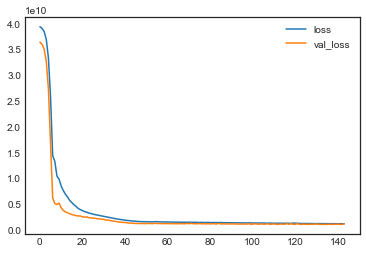

In [224]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
history = model.fit(X, y, validation_split = .1, batch_size = 128, epochs = 1000, callbacks = [early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

Epoch 1/170
12/12 [==============================] - 1s 22ms/step - loss: 39027257344.0000
Epoch 2/170
12/12 [==============================] - 0s 3ms/step - loss: 38410649600.0000
Epoch 3/170
12/12 [==============================] - 0s 3ms/step - loss: 36904046592.0000
Epoch 4/170
12/12 [==============================] - 0s 3ms/step - loss: 33030033408.0000
Epoch 5/170
12/12 [==============================] - 0s 3ms/step - loss: 24537714688.0000
Epoch 6/170
12/12 [==============================] - 0s 3ms/step - loss: 13678158848.0000
Epoch 7/170
12/12 [==============================] - 0s 3ms/step - loss: 11812794368.0000
Epoch 8/170
12/12 [==============================] - 0s 3ms/step - loss: 9749890048.0000
Epoch 9/170
12/12 [==============================] - 0s 3ms/step - loss: 8426645504.0000
Epoch 10/170
12/12 [==============================] - 0s 3ms/step - loss: 7087493632.0000
Epoch 11/170
12/12 [==============================] - 0s 3ms/step - loss: 6288757760.0000
Epoch 12/17

12/12 [==============================] - 0s 3ms/step - loss: 1268156032.0000
Epoch 93/170
12/12 [==============================] - 0s 4ms/step - loss: 1323906304.0000
Epoch 94/170
12/12 [==============================] - 0s 3ms/step - loss: 1240448768.0000
Epoch 95/170
12/12 [==============================] - 0s 4ms/step - loss: 1235099904.0000
Epoch 96/170
12/12 [==============================] - 0s 4ms/step - loss: 1223410048.0000
Epoch 97/170
12/12 [==============================] - 0s 3ms/step - loss: 1244233088.0000
Epoch 98/170
12/12 [==============================] - 0s 4ms/step - loss: 1242618112.0000
Epoch 99/170
12/12 [==============================] - 0s 3ms/step - loss: 1221867008.0000
Epoch 100/170
12/12 [==============================] - 0s 4ms/step - loss: 1215520384.0000
Epoch 101/170
12/12 [==============================] - 0s 4ms/step - loss: 1212207488.0000
Epoch 102/170
12/12 [==============================] - 0s 4ms/step - loss: 1204174976.0000
Epoch 103/170
12/12 

<AxesSubplot:>

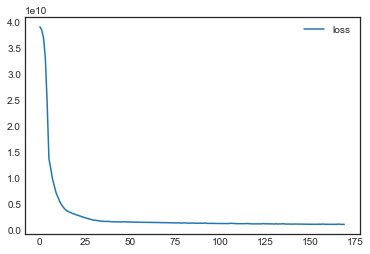

In [225]:
model = create_model()
history = model.fit(X, y, batch_size = 128, epochs = 170)
losses = pd.DataFrame(model.history.history)
losses.plot()

## Prediction / Evaluation
    - 평가 전에 Train_data와 같은 Scale방식으로 Test_data를 Scale
    - StandardScaler function from sklearn

In [226]:
scale = StandardScaler()
X_test = scale.transform(test)

result = model.predict(X_test)
result = pd.DataFrame(result, columns = ['SalePrice'])
result['Id'] = test['Id']
result = result[['Id', 'SalePrice']]
result.head()

,Id,SalePrice
0,1461,110.378433
1,1462,67.663361
2,1463,2469.509766
3,1464,4059.954834
4,1465,3684.760498


# Result
    1. 좀 더 다양한 전처리방법(결측치처리, 이상치처리 등)에 대해 알게되었다
    2. EDA 단계에서의 시각화 처리능력이 향상되었다
    3. IsolationForest를 통해 Outliers들을 파악하고 데이터에 적용하는 방법을 알게되었다
    4. Keras의 Model Tuning 방법에대해 알게되었다
    5. EarlyStopping API에 대해 좀 더 깊은 공부를 할 수 있게되었다
    6. 해당 데이터셋에 Keras는 가장 적합한 모델이 아닌것같음